In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# King County 지역의 집값 예측
- hypothesis 
    - 일반적인 가정을 해보자. 우리나라의 집값 상황과 비슷할 것이다.
    - 집이 크면 비쌀것.(방이 많으면 넓은건지도 확인)
    - 새 아파트일수록 비쌀것
    - 지어진지 얼마 안된 집은 비쌀것
    - 리모델링 연도 확인(지어진 연도와 현재 연도의 차이와, 지어진 연도와 리노베이트한 연도의 차이, 리노베이트한 연도와 현재 연도의 차이 비교)

### load data

In [299]:
train_data = pd.read_csv('kc_house_data.csv')
print(train_data.shape)
train_data.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [300]:
# 수치형 데이터 20개(실수형(5개), 정수형(15개)), 명목형 데이터 1개, 누락값은 없다. 상당히 깨끗함
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


### 컬럼 확인

In [301]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### 결측치 확인

In [302]:
# 결측치 없음
train_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [303]:
train_data[['price', 'bedrooms', 'bathrooms', 'condition', 'view', 'grade']].head()

,price,bedrooms,bathrooms,condition,view,grade
0,221900.0,3,1.00,3,0,7
1,538000.0,3,2.25,3,0,7
2,180000.0,2,1.00,3,0,6
3,604000.0,4,3.00,5,0,7
4,510000.0,3,2.00,3,0,8


In [304]:
train_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [305]:
train_data.median()

id               3.904930e+09
price            4.500000e+05
bedrooms         3.000000e+00
bathrooms        2.250000e+00
sqft_living      1.910000e+03
sqft_lot         7.618000e+03
floors           1.500000e+00
waterfront       0.000000e+00
view             0.000000e+00
condition        3.000000e+00
grade            7.000000e+00
sqft_above       1.560000e+03
sqft_basement    0.000000e+00
yr_built         1.975000e+03
yr_renovated     0.000000e+00
zipcode          9.806500e+04
lat              4.757180e+01
long            -1.222300e+02
sqft_living15    1.840000e+03
sqft_lot15       7.620000e+03
dtype: float64

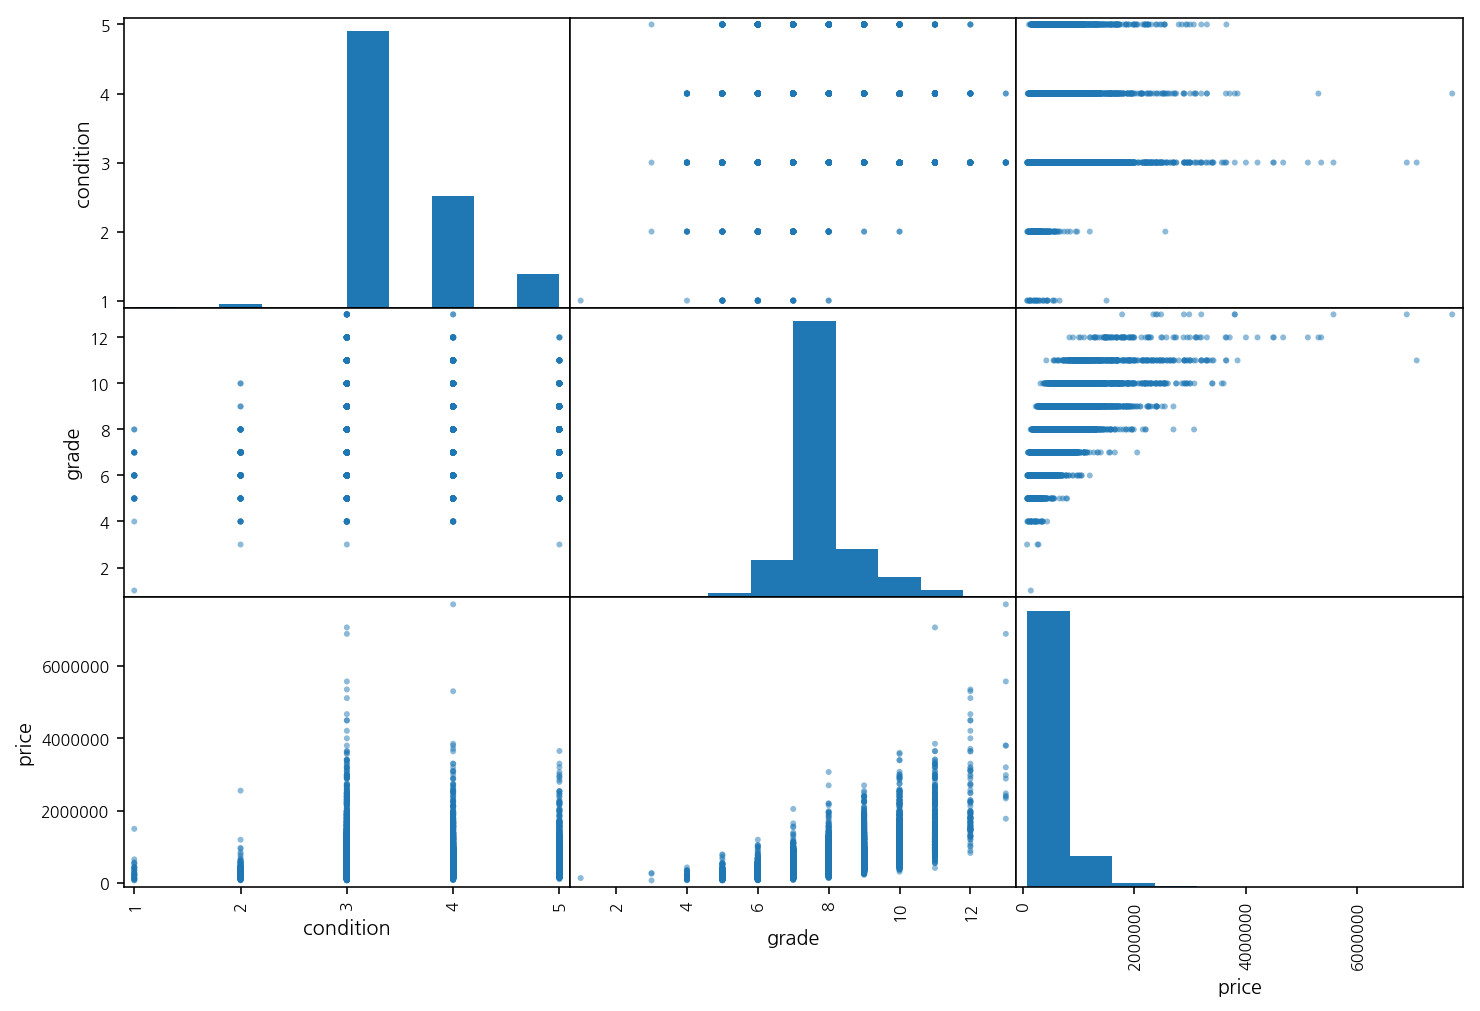

In [306]:
from pandas.plotting import scatter_matrix

attributes = ['condition', 'grade', 'price']
scatter_matrix(train_data[attributes], figsize=(12, 8))
plt.show()

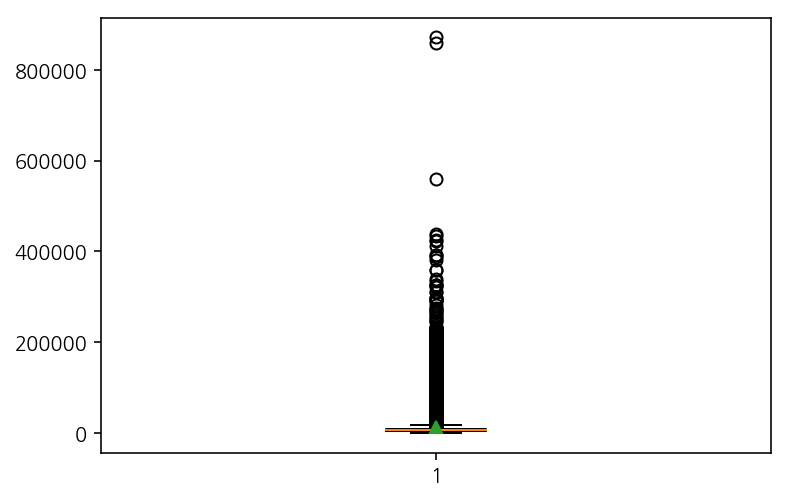

In [307]:
plt.boxplot(train_data['sqft_lot15'], showmeans=True)
plt.show()

In [308]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

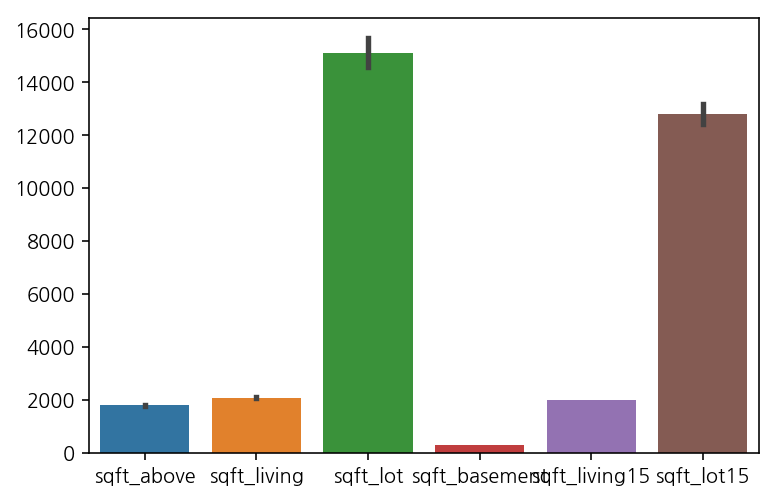

In [310]:
sns.barplot(data=train_data[['sqft_above', 'sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15', 'sqft_lot15']])
plt.show()

In [311]:
train_data['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [312]:
train_data.loc[train_data['price'] > 645000].count()

id               5373
date             5373
price            5373
bedrooms         5373
bathrooms        5373
sqft_living      5373
sqft_lot         5373
floors           5373
waterfront       5373
view             5373
condition        5373
grade            5373
sqft_above       5373
sqft_basement    5373
yr_built         5373
yr_renovated     5373
zipcode          5373
lat              5373
long             5373
sqft_living15    5373
sqft_lot15       5373
dtype: int64

In [313]:
from sklearn.linear_model import LinearRegression
model_house = LinearRegression().fit(train_data[['bedrooms', 'view', 'grade']], train_data[['price']])

In [314]:
model_house.coef_

array([[ 32843.45502722, 117822.15860343, 179876.72462565]])

In [315]:
model_house.intercept_

array([-975521.34736363])

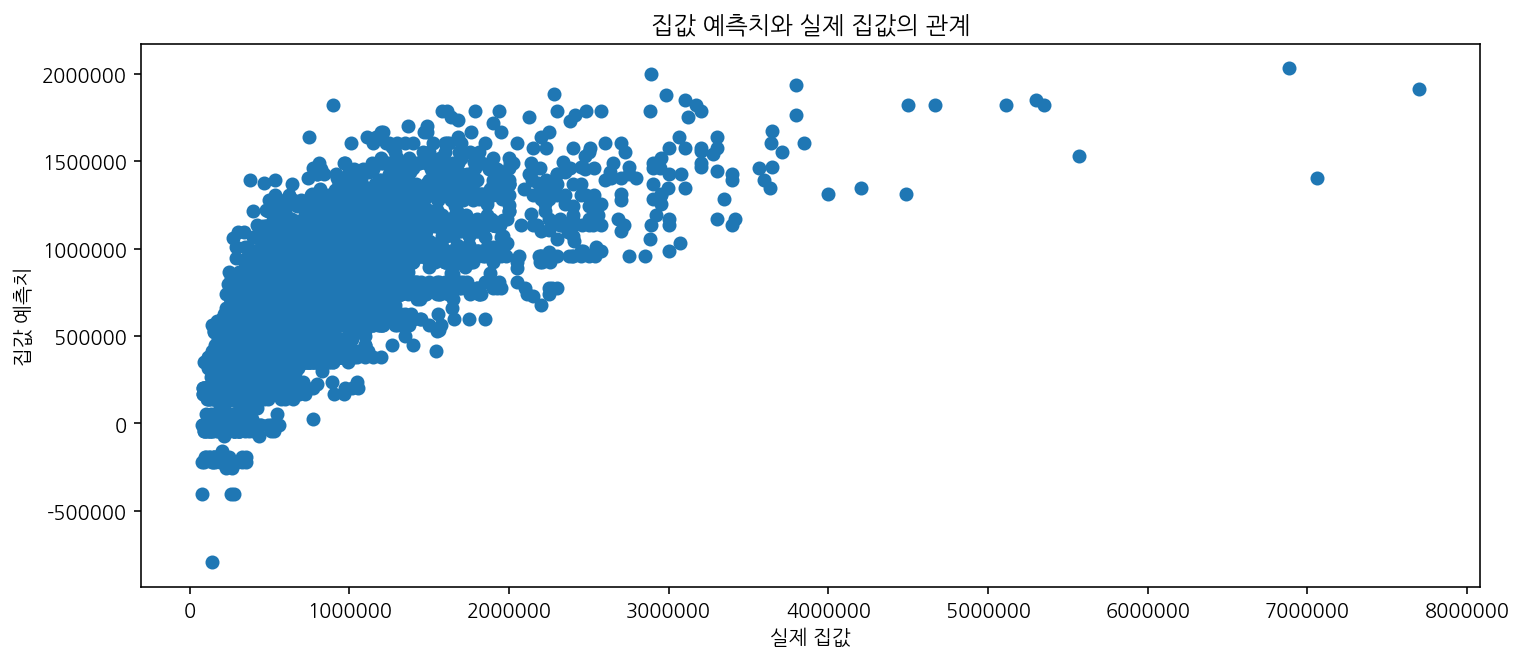

In [319]:
predictions = model_house.predict(train_data[['bedrooms', 'view', 'grade']])
plt.figure(figsize=(12, 5))
plt.scatter(train_data[['price']], predictions)
plt.xlabel(u"실제 집값")
plt.ylabel(u"집값 예측치")
plt.title("집값 예측치와 실제 집값의 관계")
plt.show()


### sqrt 컬럼 모아서 보기

In [320]:
train_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [321]:
sqrt_columns = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

In [322]:
train_data[sqrt_columns].head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,221900.0,1180,5650,1180,0,1340,5650
1,538000.0,2570,7242,2170,400,1690,7639
2,180000.0,770,10000,770,0,2720,8062
3,604000.0,1960,5000,1050,910,1360,5000
4,510000.0,1680,8080,1680,0,1800,7503


In [323]:
train_data[sqrt_columns].corr()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
price,1.000000,0.702035,0.089661,0.605567,0.323816,0.585379,0.082447
sqft_living,0.702035,1.000000,0.172826,0.876597,0.435043,0.756420,0.183286
sqft_lot,0.089661,0.172826,1.000000,0.183512,0.015286,0.144608,0.718557
sqft_above,0.605567,0.876597,0.183512,1.000000,-0.051943,0.731870,0.194050
sqft_basement,0.323816,0.435043,0.015286,-0.051943,1.000000,0.200355,0.017276
sqft_living15,0.585379,0.756420,0.144608,0.731870,0.200355,1.000000,0.183192
sqft_lot15,0.082447,0.183286,0.718557,0.194050,0.017276,0.183192,1.000000


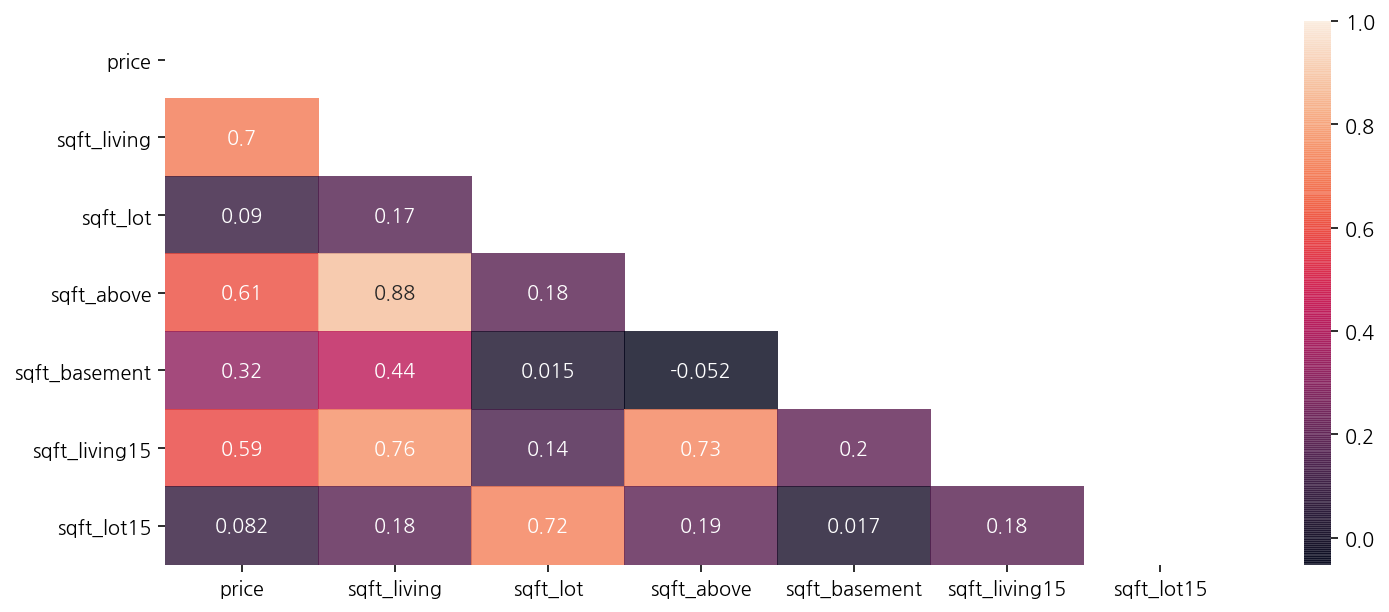

In [324]:
mask2 = np.zeros_like(train_data[sqrt_columns].corr(), dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True
plt.figure(figsize=(12, 5))
sns.heatmap(train_data[sqrt_columns].corr(), annot=True, alpha=0.8, mask=mask2)
plt.show()

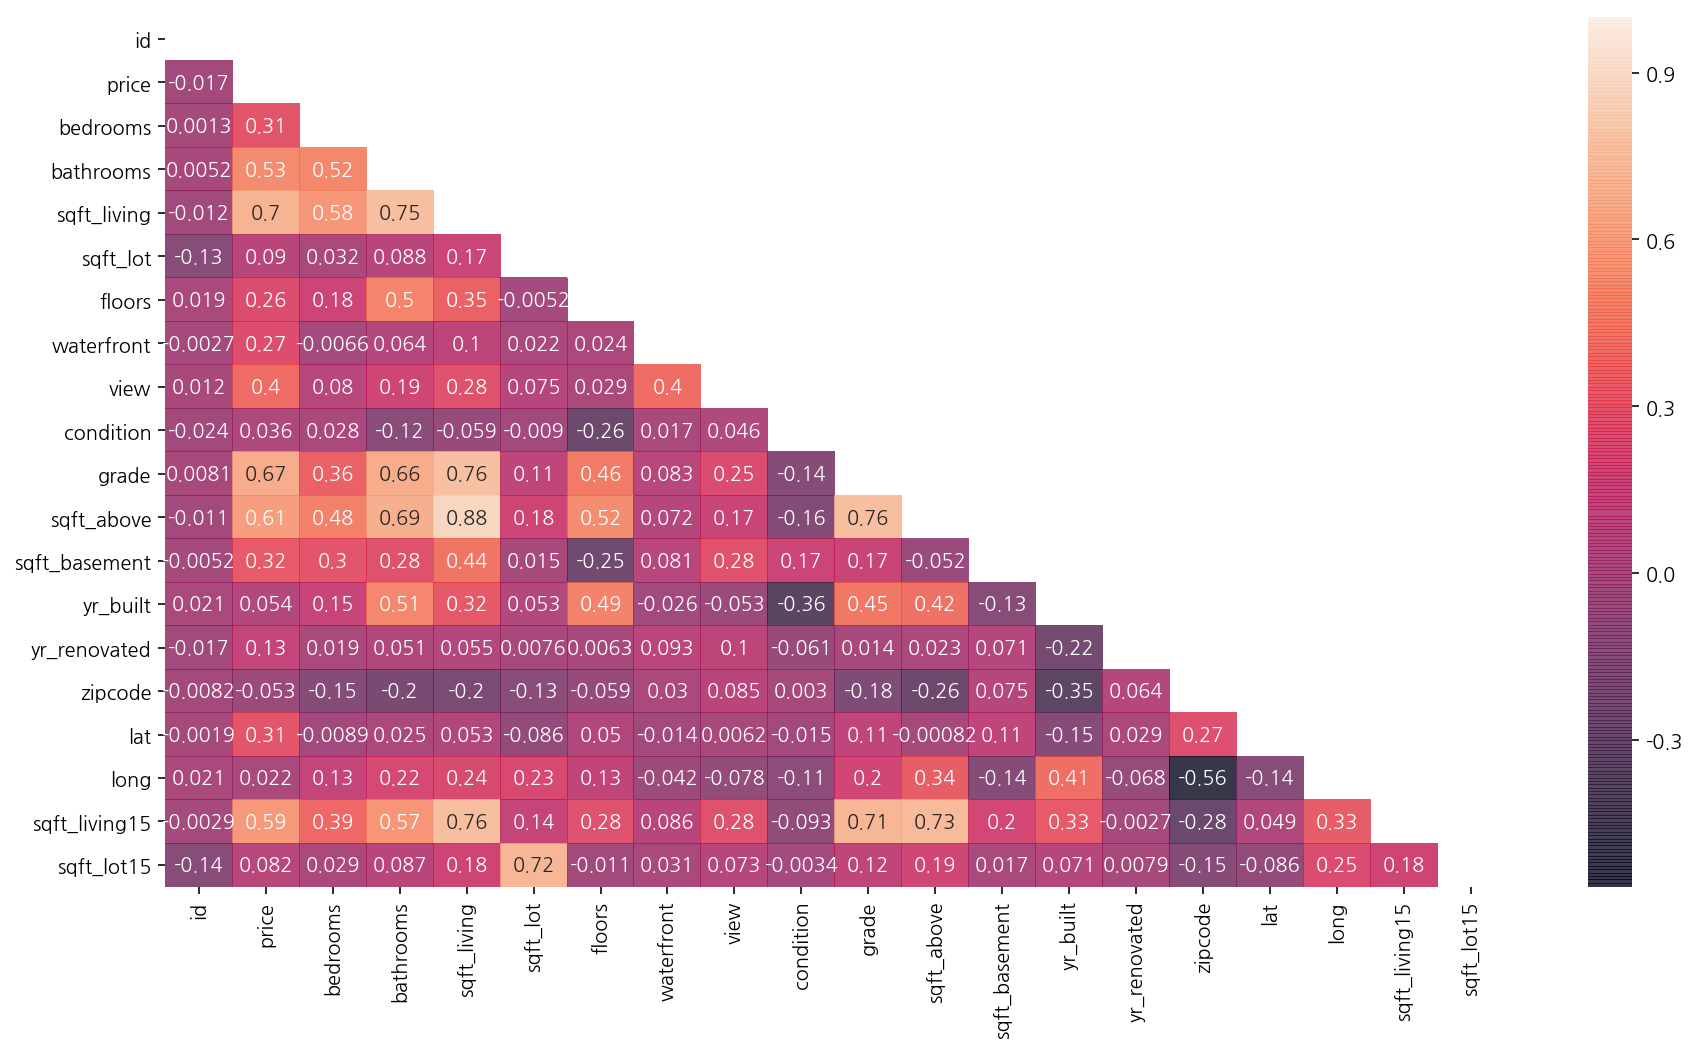

In [325]:
mask = np.zeros_like(train_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15, 8))
sns.heatmap(train_data.corr(), annot=True, alpha=0.8, mask=mask)
plt.show()

In [326]:
'price','bedrooms','bathrooms','sqft_living','floors','grade','yr_built','condition'

('price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'grade',
 'yr_built',
 'condition')

In [327]:
X = dataset.iloc[:,1:].values
y = dataset.iloc[:,0].values

In [328]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [329]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15129, 18), (6484, 18), (15129,), (6484,))

In [330]:
dataset = train_data.copy().drop(['id'],axis=1)

In [331]:
mlr = LinearRegression()
mlr.fit(x_train,y_train)
mlr_score = mlr.score(x_test,y_test)
pred_mlr = mlr.predict(x_test)
expl_mlr = explained_variance_score(pred_mlr,y_test)

In [332]:
mlr_score

0.6877902899299386

In [333]:
rf_regressor = RandomForestRegressor(n_estimators=28,random_state=0)
rf_regressor.fit(x_train,y_train)
rf_regressor.score(x_test,y_test)
rf_pred =rf_regressor.predict(x_test)
rf_score=rf_regressor.score(x_test,y_test)
expl_rf = explained_variance_score(rf_pred,y_test)

In [334]:
rf_regressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=28, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [335]:
rf_score

0.8801096841940461

In [336]:
expl_mlr

0.5275283032363549

In [337]:
pd.DataFrame({'Explained model score': [expl_mlr, expl_rf]})

,Explained model score
0,0.527528
1,0.846248


In [338]:
train_data['yr_built'].unique()

array([1955, 1951, 1933, 1965, 1987, 2001, 1995, 1963, 1960, 2003, 1942,
       1927, 1977, 1900, 1979, 1994, 1916, 1921, 1969, 1947, 1968, 1985,
       1941, 1915, 1909, 1948, 2005, 1929, 1981, 1930, 1904, 1996, 2000,
       1984, 2014, 1922, 1959, 1966, 1953, 1950, 2008, 1991, 1954, 1973,
       1925, 1989, 1972, 1986, 1956, 2002, 1992, 1964, 1952, 1961, 2006,
       1988, 1962, 1939, 1946, 1967, 1975, 1980, 1910, 1983, 1978, 1905,
       1971, 2010, 1945, 1924, 1990, 1914, 1926, 2004, 1923, 2007, 1976,
       1949, 1999, 1901, 1993, 1920, 1997, 1943, 1957, 1940, 1918, 1928,
       1974, 1911, 1936, 1937, 1982, 1908, 1931, 1998, 1913, 2013, 1907,
       1958, 2012, 1912, 2011, 1917, 1932, 1944, 1902, 2009, 1903, 1970,
       2015, 1934, 1938, 1919, 1906, 1935])

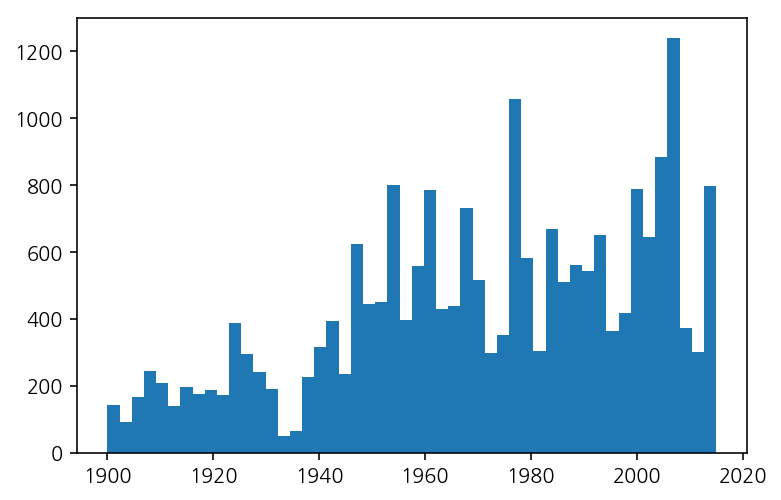

In [339]:
plt.hist(train_data['yr_built'], bins=50, range=(1900, 2015))
plt.show()

In [340]:
built_columns = train_data.copy()
built_columns = built_columns[['yr_built', 'yr_renovated']]
built_columns['built_twenties'] = built_columns['yr_built'] < 2000
built_columns['built_twenty_first'] = built_columns['yr_built'] >= 2000
built_columns.head()

,yr_built,yr_renovated,built_twenties,built_twenty_first
0,1955,0,True,False
1,1951,1991,True,False
2,1933,0,True,False
3,1965,0,True,False
4,1987,0,True,False


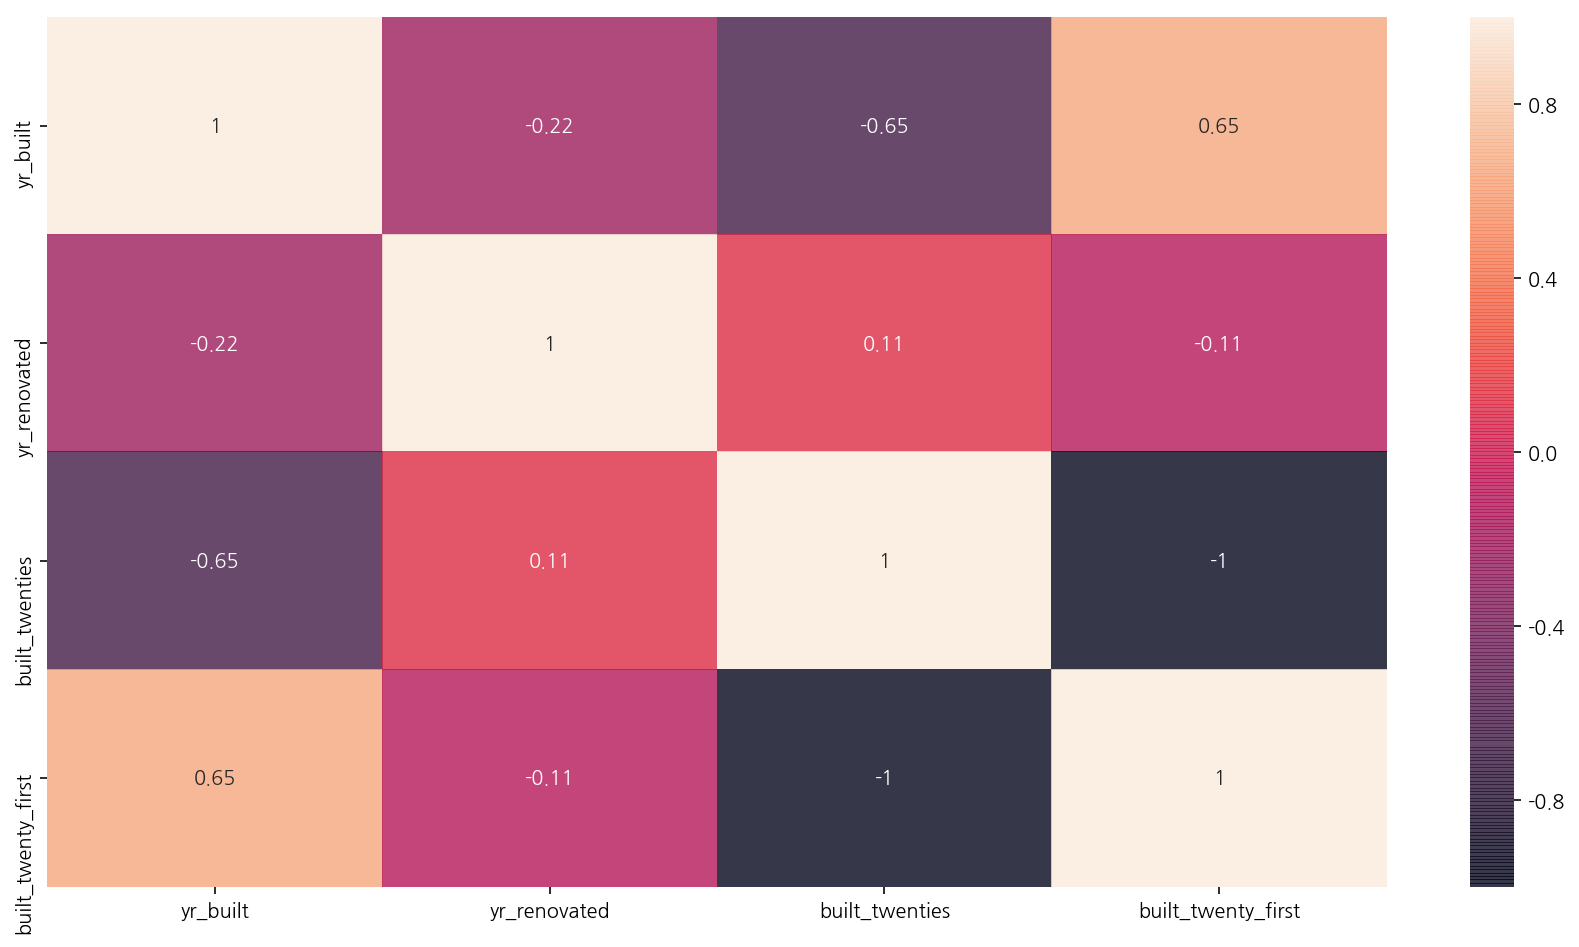

In [341]:
plt.figure(figsize=(15, 8))
sns.heatmap(built_columns.corr(), annot=True, alpha=0.8)
plt.show()

In [343]:
train_data['yr_renovated'].head()

0       0
1    1991
2       0
3       0
4       0
Name: yr_renovated, dtype: int64

In [414]:
df_preprocessing = train_data.copy()

In [415]:
# df_preprocessing['sold_year'] = df_preprocessing['date']
def date_to_year(data):
    ls = []
    for i, v in enumerate(data):
        ls.append(data[i][:4])
    return ls

In [416]:
def date_to_month(data):
    ls = []
    for i, v in enumerate(data):
        ls.append(data[i][4:6])
    return ls

In [417]:
df_preprocessing['sold_year'] = date_to_year(df_preprocessing['date'])
df_preprocessing['sold_month'] = date_to_month(df_preprocessing['date'])

In [418]:
df_preprocessing['house_age'] = df_preprocessing['sold_year'].astype(int) - df_preprocessing['yr_built']

In [419]:
bins = [-2,0,5,10,25,50,75,100,100000] # 지어진지 10년까지는 1년 미만, 5년 미만, 10년 미만으로 나눠주고 10년 이상은 25년 단위로 끊는다.
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df_preprocessing['age_binned'] = pd.cut(df_preprocessing['house_age'], bins=bins, labels=labels)
df_preprocessing[['age_binned']].head()

,age_binned
0,51-75
1,51-75
2,76-100
3,26-50
4,26-50


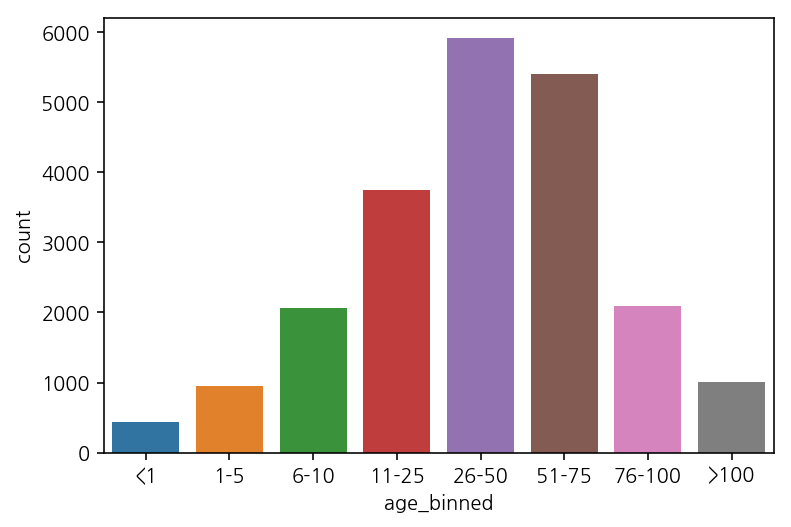

In [420]:
sns.countplot(df_preprocessing['age_binned'])
plt.show()

In [423]:
df_preprocessing = pd.get_dummies(df_preprocessing, columns=(['age_binned']))

,age_binned_<1,age_binned_1-5,age_binned_11-25,age_binned_51-75,age_binned_6-10,price
age_binned_<1,1.000000,-0.030931,-0.066171,-0.083419,-0.046987,0.056568
age_binned_1-5,-0.030931,1.000000,-0.098034,-0.123587,-0.069613,0.028191
age_binned_11-25,-0.066171,-0.098034,1.000000,-0.264396,-0.148926,0.073469
age_binned_51-75,-0.083419,-0.123587,-0.264396,1.000000,-0.187745,-0.116238
age_binned_6-10,-0.046987,-0.069613,-0.148926,-0.187745,1.000000,0.064505
price,0.056568,0.028191,0.073469,-0.116238,0.064505,1.000000


In [426]:
df_preprocessing.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sold_year', 'sold_month',
       'house_age', 'age_binned_<1', 'age_binned_1-5', 'age_binned_6-10',
       'age_binned_11-25', 'age_binned_26-50', 'age_binned_51-75',
       'age_binned_76-100', 'age_binned_>100'],
      dtype='object')

In [434]:
df_preprocessing

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sold_month,house_age,age_binned_<1,age_binned_1-5,age_binned_6-10,age_binned_11-25,age_binned_26-50,age_binned_51-75,age_binned_76-100,age_binned_>100
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,10,59,0,0,0,0,0,1,0,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,12,63,0,0,0,0,0,1,0,0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,02,82,0,0,0,0,0,0,1,0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,12,49,0,0,0,0,1,0,0,0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,02,28,0,0,0,0,1,0,0,0
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,05,13,0,0,0,1,0,0,0,0
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,06,19,0,0,0,1,0,0,0,0
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,01,52,0,0,0,0,0,1,0,0
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,04,55,0,0,0,0,0,1,0,0
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,03,12,0,0,0,1,0,0,0,0


In [445]:
dataset2 = df_preprocessing.copy().drop(['date'],axis=1)

In [446]:
X = dataset2.iloc[:,1:].values
y = dataset2.iloc[:,0].values

In [447]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [448]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((15129, 30), (6484, 30), (15129,), (6484,))

In [449]:
rf_regressor = RandomForestRegressor(n_estimators=28,random_state=0)
rf_regressor.fit(train_x,train_y)
rf_regressor.score(test_x,test_y)
rf_pred =rf_regressor.predict(test_x)
rf_score=rf_regressor.score(test_x, test_y)
expl_rf = explained_variance_score(rf_pred,test_y)

In [453]:
rf_regressor

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=28, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [454]:
mlr = LinearRegression()
mlr.fit(train_x, train_y)
mlr_score = mlr.score(test_x, test_y)
pred_mlr = mlr.predict(test_x)
expl_mlr = explained_variance_score(pred_mlr, test_y)

In [456]:
mlr_score

0.02624920754511395

In [488]:
from sklearn.ensemble import GradientBoostingRegressor
est=GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.05).fit(x_train, y_train)
gradient=est.score(x_test,y_test)
pred = est.predict(x_test)
exp_est = explained_variance_score(pred,y_test)

In [489]:
est

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [490]:
gradient

0.9013404093204983

In [492]:
exp_est

0.8816873095155446

In [493]:
import lightgbm as lgb

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [506]:
d_train = lgb.Dataset(x_train, label=y_train)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'gamma'
params['metric'] = 'l1'
params['sub_feature'] = 0.5
params['num_leaves'] = 40
params['min_data'] = 50
params['max_depth'] = 30

lgb_model = lgb.train(params, d_train, 1000)

#Prediction
y_pred = lgb_model.predict(x_test)
exp_est = explained_variance_score(y_pred,y_test)

In [507]:
exp_est

0.8696510621820954

In [ ]:
from sklearn.linear_model import LogisticRegression
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(x_train, y_train)